In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Data cleaning and preprocessing

* Load data and check data types & null value

In [2]:
df = pd.read_csv("bank-additional-full.csv", delimiter=";") # Load data
df.info() #check data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Based on above information, the data type for each column is correct and there is no null value

In [3]:
df.head() #check first few rows of data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


* Check unique value of each categorical feature

In [4]:
#function that check unique values of categorical columns
def unique_categorical_columns(df):
    for column in df.columns:
        if df[column].dtype == "object":
            print(f"{column}: {df[column].unique()}")

In [5]:
unique_categorical_columns(df) #check unique categorical values based on description.docx

job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital: ['married' 'single' 'divorced' 'unknown']
education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default: ['no' 'unknown' 'yes']
housing: ['no' 'yes' 'unknown']
loan: ['no' 'yes' 'unknown']
contact: ['telephone' 'cellular']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome: ['nonexistent' 'failure' 'success']
y: ['no' 'yes']


based on information above, the value is match with value that described in Description.docx

* Check feature corelation with corelation matrix

<Axes: >

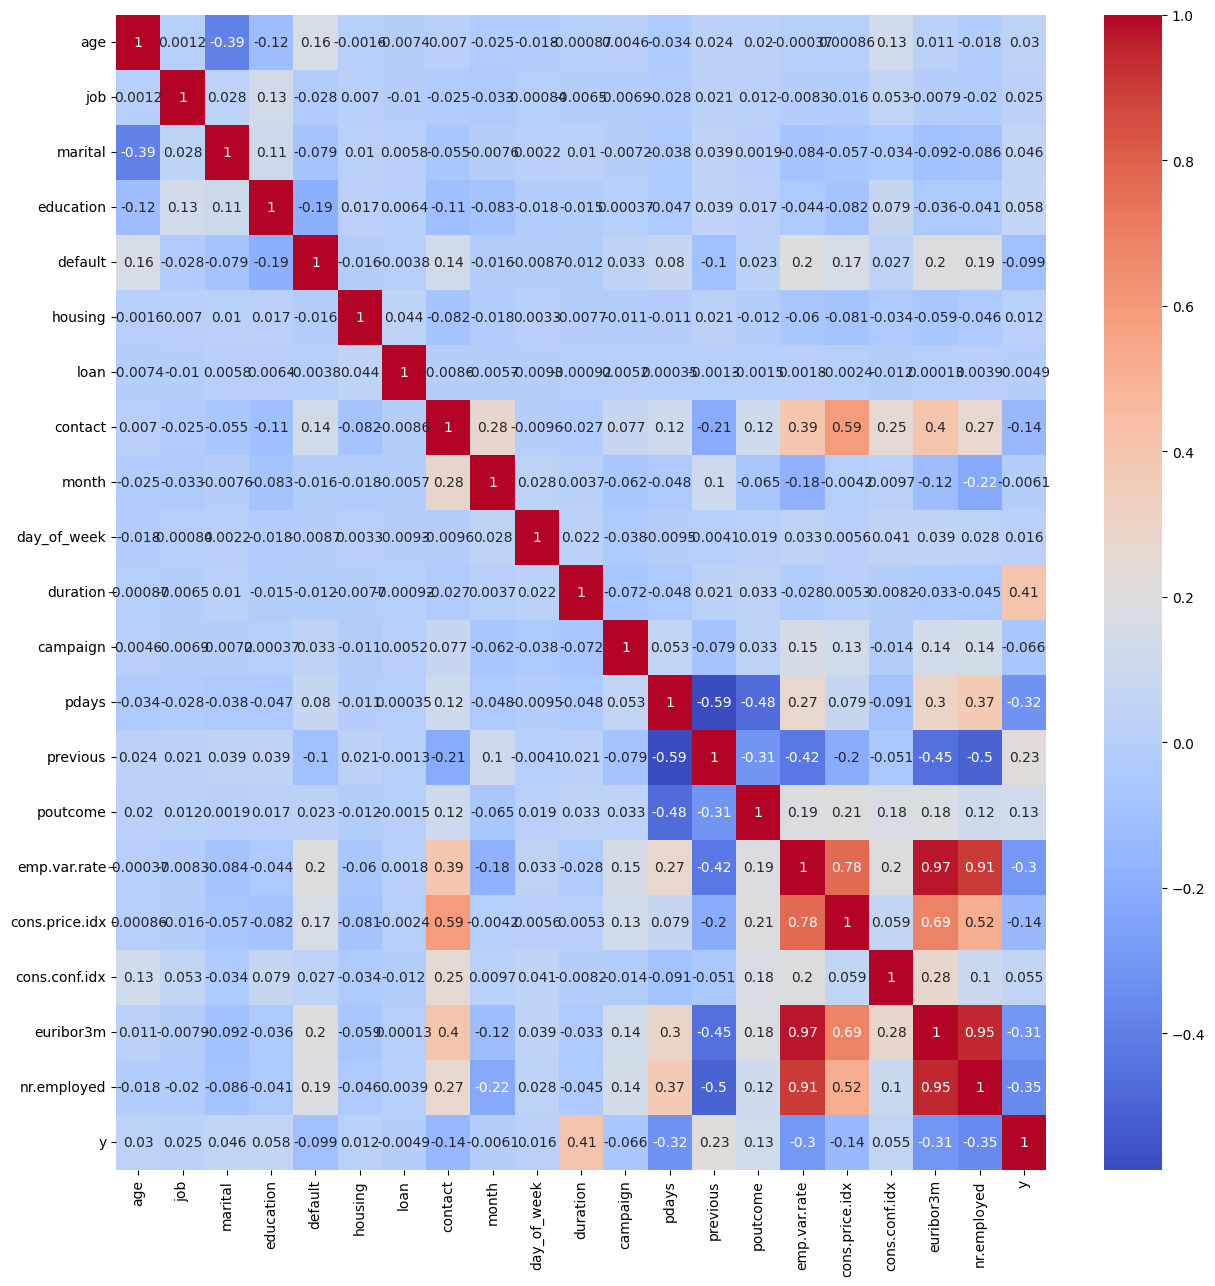

In [6]:
# check feature corelation with corelation matrix
df_corr = df.copy()

#encode categorical columns
label_encoder = LabelEncoder()
for i in df_corr.columns:
    if df_corr[i].dtype == "object":
        df_corr[i] = label_encoder.fit_transform(df_corr[i])

#plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm")

The correlation coefficient ranges from -1 to 1, where -1 means that the two variables are perfectly negatively correlated, 1 means that the two variables are perfectly positively correlated, and 0 means that there is no correlation between the two variables.

For example, the correlation coefficient between "age" and "job" is -0.0012, which means that there is a very weak negative correlation between the two variables. Similarly, the correlation coefficient between "job" and "job" is 1, which means that there is a perfect positive correlation between a variable and itself.

Based on the graph above, there is corelation on some feature that labeled with reddish color or above 0.50 score. Some features have strong corelation, the list of strong corelation :

* emp.var.rate & euribor3m with 0.97 score
* nr.employed & emp.var.rate with 0.91 score
* euribor3m & nr.employed with 0.95 score
* cons.price.idx & emp.var.rate with 0.78 score
* euribor3m & cons.price idx with 0.69 score
* cons.price.idx & contact with 0.59 score

* Check outlier on data and remove missing value

For checking outlier in this huge data, we can use zscore method to identify outlier on the data. Outliers can easily identify if the data zscore is above 3.

In [7]:
z_scores = zscore(df.select_dtypes(include="number"))
outliers = z_scores > 3
sum_of_outliers = np.sum(outliers)
print(sum_of_outliers) #check for outliers

age                369
duration           861
campaign           869
pdays                0
previous          1064
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
dtype: int64


d:\Anaconda\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


The outlier for duration, campaign and previous has extreme value of outliers, we need to check that the value for that features is not really outlier.

<Axes: xlabel='previous', ylabel='Count'>

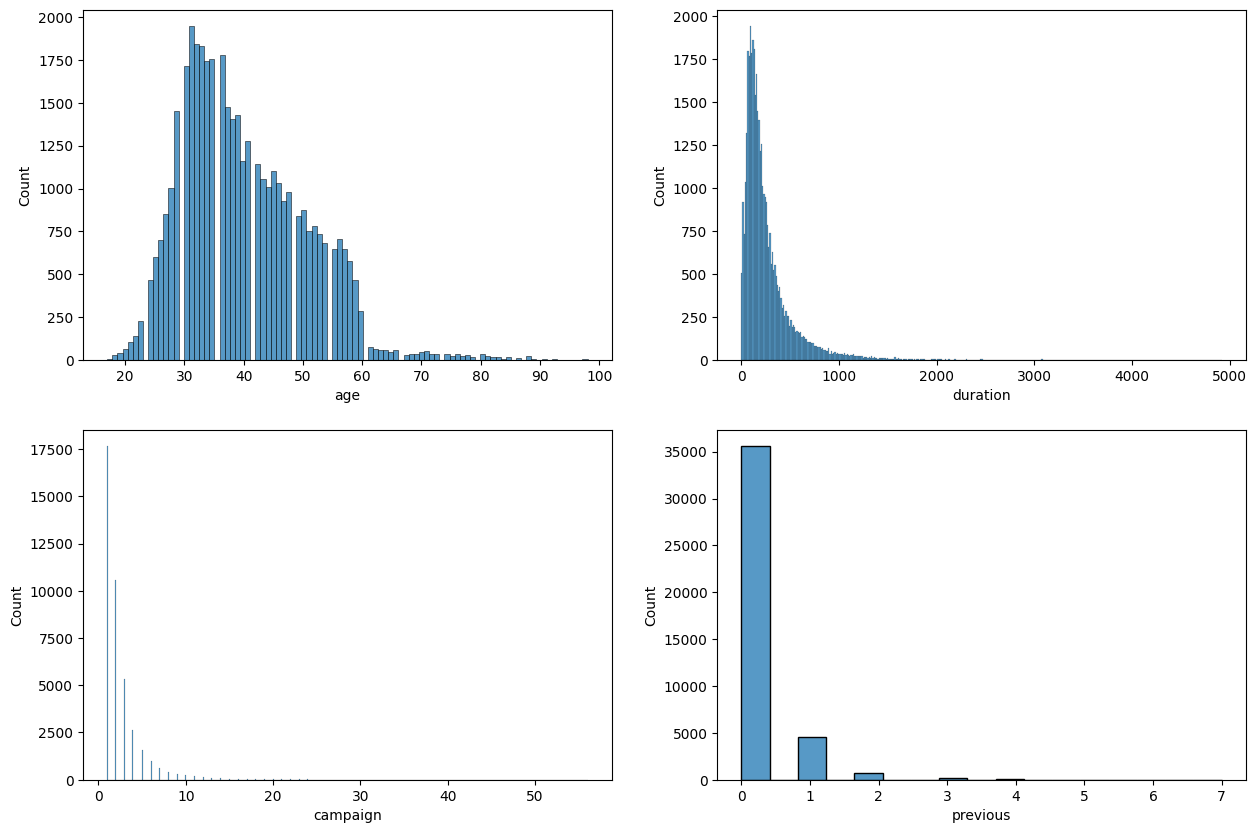

In [8]:
sub_fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df["age"], ax=axes[0, 0])
sns.histplot(df["duration"], ax=axes[0, 1])
sns.histplot(df["campaign"], ax=axes[1, 0])
sns.histplot(df["previous"], ax=axes[1, 1])

based on graph above, we analyze that
* Age feature has no outlier since the individuals age is below 100, and it's normal for age with range 50 - 90 to engage with telemarketing
* Duration feature has no outlier since the duration of the call is not above 1 hour and it's considerably normal
* campaign feature has data that above 10 calls engagement, in the context bank telemarketing where the individuals applying deposit is normal behavior.
* Previous feature has data that above 0, the individual perform contact with the bank before the campaign occur. There is only few data with few contact on the graph, so there is not outlier

from above analysis, it's safe to say that there is no outlier for this data. Thing we only have to do is to remove the data with empty value, firstly we replace "unknown" with NaN and then drop data with NaN using dropna function

In [9]:
# Drop data with unknown values
df.replace("unknown", np.nan, inplace=True) #replace unknown with NaN
df.dropna(inplace=True) #drop rows with NaN values

In [10]:
df.shape #check data shape after cleaning

(30488, 21)

# Feature Engineering

Feature Engineering is very important because it provide more context of the data so the model can easily converge. creating feature with feature engineering requires data understanding and objective of this model.

This is the feature that relevant and might be help model to predict more easily :
* total_previous_contacts : This feature combines the number of contacts performed before and during the current campaign, providing a comprehensive view of the client's engagement history. It considers both previous contacts and the outcome of the last contact, potentially capturing the client's responsiveness to marketing efforts.


* contacted_last_month : This binary feature indicates whether the client was contacted in the last month. Seasonal trends or recent interactions might influence the client's decision, making this feature relevant for predicting subscription propensity.

In [11]:
# make copy of dataframe
df_2 = df.copy()

# Feature: Total number of previous contacts
df_2['total_previous_contacts'] = df_2['previous'] + df_2['pdays'].apply(lambda x: 0 if x == 999 else 1)

# Feature: Contacted in the last month
df_2['contacted_last_month'] = np.where(df_2['month'] == 'feb', 1, 0)  # last month for this date is february   

# Data normalization and encoding

In order to make the model converge faster, we need to normalize the data. Normalization makes the value is smaller (range of 0 - 1) and it requires less computational than without normalization. The normalization is a must because the age data is always above 0 and another feature like euribor has value decimal. The gap of the value is make the model difficult to converge.

We also encode the categorical feature in order to make the data can fed into the model. for encoding we can use LabelEncoder function to automaticly encode all categorical feature.

In [12]:
# copy cleaned dataframe
df_normalized = df_2.copy()

# Normalizing numerical variables to make the model converge faster
numerical_columns = df_normalized.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df_normalized[numerical_columns] = scaler.fit_transform(df_normalized[numerical_columns])

# converting categorical variables to numerical
for column in df_normalized.columns:
    if df_normalized[column].dtype == "object":
        le = LabelEncoder()
        df_normalized[column] = le.fit_transform(df_normalized[column])
        

# df_normalized now contains normalized numerical features and encoded categorical features

In [13]:
df_normalized.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,total_previous_contacts,contacted_last_month
0,0.500000,3,1,0,0,0,0,1,6,1,...,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,0.0,0
2,0.256410,7,1,3,0,1,0,1,6,1,...,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,0.0,0
3,0.294872,0,1,1,0,0,0,1,6,1,...,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,0.0,0
4,0.500000,7,1,3,0,0,1,1,6,1,...,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,0.0,0
6,0.538462,0,1,5,0,0,0,1,6,1,...,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,0.0,0


# Data balancing

The next step is we need to do data balancing, firstly we need to check the distribution of the data by using pie graph

([<matplotlib.patches.Wedge at 0x28eeee81d90>,
 [Text(-1.0141729876629155, 0.42597318119205113, 'No'),
  Text(1.0141729876629153, -0.4259731811920517, 'Yes')],
 [Text(-0.5531852659979538, 0.23234900792293695, '87.3%'),
  Text(0.5531852659979537, -0.23234900792293725, '12.7%')])

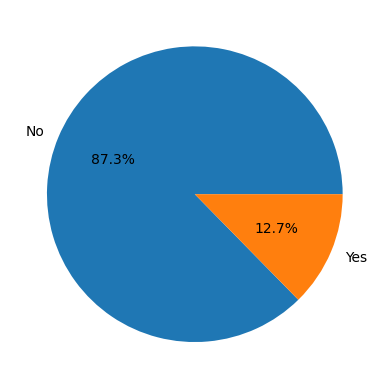

In [14]:
# check data balance before training
plt.pie(df_normalized['y'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')

Based on graph above, the data is massively imbalance with yes 12.7%. Data balancing is important because we want to make the model not to memorize the "No" data and make the model more likely predict "No".

For data balance, we use SMOTE(Synthetic Minority Oversampling Technique) to balance the data. SMOTE can generate synthetic instances by interpolating between existing minority class instances. this sampling technique can avoid overfitting compared to using random oversampling where the minority data is only copied until the data is balance.

final step of preprocessing is we need to split training data and test data. training data is used by model to change the weight of the model so it can generalize well with the data, while test data is used in evaluation phase where we need to test the model if the model performance is capable to perform well in real life world scenario

In [15]:
# split features to X and target to Y
X = df_normalized.drop('y', axis=1)
y = df_normalized['y']

# since "No" has massive majority, we need to use oversampling Yes data to balance the data and avoid data reduction
smote = SMOTE(sampling_strategy='minority') 
X, y = smote.fit_resample(X, y)

# Split the data into training and testing sets
x_resampled, X_test, y_resampled, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y
0    21329
1    21277
Name: count, dtype: int64

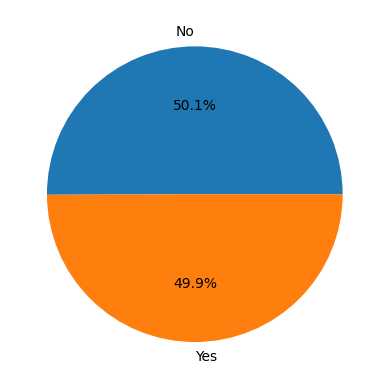

In [16]:
# check the balance
plt.pie(y_resampled.value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
y_resampled.value_counts()

# Training

In training phase, we define the model first and do fitting using training data. i choose the boosting classifier, random forest classifier, and logisctic regression model. Reason i choose this three model because it's most suitable model for classification problem.

After training, the result of model accuracy using test data is shown.

In [17]:
# Boosting Tree Model
boosting_model = GradientBoostingClassifier()
boosting_model.fit(x_resampled, y_resampled)
boosting_predictions = boosting_model.predict(X_test)

# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(x_resampled, y_resampled)
rf_predictions = rf_model.predict(X_test)

# Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(x_resampled, y_resampled)
logreg_predictions = logreg_model.predict(X_test)

# Evaluate models
print("Boosting Model Accuracy:", accuracy_score(y_test, boosting_predictions))
print("Random Forest Model Accuracy:", accuracy_score(y_test, rf_predictions))
print("Logistic Regression Model Accuracy:", accuracy_score(y_test, logreg_predictions))


Boosting Model Accuracy: 0.9233946676680436
Random Forest Model Accuracy: 0.9477093503567405
Logistic Regression Model Accuracy: 0.8768306421329328


# Model Testing

In model testing phase, we need to evaluate this three model using another metrics beside accuracy. The suitable metrics for model evaluation is precision, recall, and f1-score. we can easily get the result by using classification report

In [18]:
# Test models using test set data
print("Classification Report for Boosting Model:")
print(classification_report(y_test, boosting_predictions))
print("Classification Report for Random Forest Model:")
print(classification_report(y_test, rf_predictions))
print("Classification Report for Logistic Regression Model:")
print(classification_report(y_test, logreg_predictions))

Classification Report for Boosting Model:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      5300
           1       0.90      0.95      0.93      5352

    accuracy                           0.92     10652
   macro avg       0.93      0.92      0.92     10652
weighted avg       0.92      0.92      0.92     10652

Classification Report for Random Forest Model:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5300
           1       0.93      0.97      0.95      5352

    accuracy                           0.95     10652
   macro avg       0.95      0.95      0.95     10652
weighted avg       0.95      0.95      0.95     10652

Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      5300
           1       0.87      0.89      0.88      5352

    accuracy                           0

From the result above, The random forest model outperformed logistic regression and boosting model. The random forest model capable to identify and capture positive instances very well.

Boosting model performance is good enough but it lacks in label 0 recall and label 1 precision. for the logistic regression model it's not perform well, the model is underfit compared to boosting and random forest model.

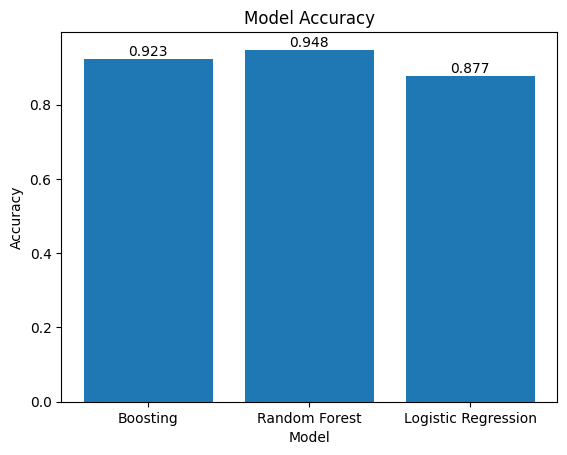

In [19]:
# plot model accuracy
model_accuracies = [accuracy_score(y_test, boosting_predictions), accuracy_score(y_test, rf_predictions), accuracy_score(y_test, logreg_predictions)]
model_names = ['Boosting', 'Random Forest', 'Logistic Regression']
plt.bar(model_names, model_accuracies)
for i in range(len(model_accuracies)):
    plt.text(i, model_accuracies[i], f"{model_accuracies[i]:.3f}", ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

Based on the graph above, the random forest model won the overall accuracy with 95% accuracy, boosting model perform well too with 92% accuracy, and logistic regression is underperform with 88% accuracy

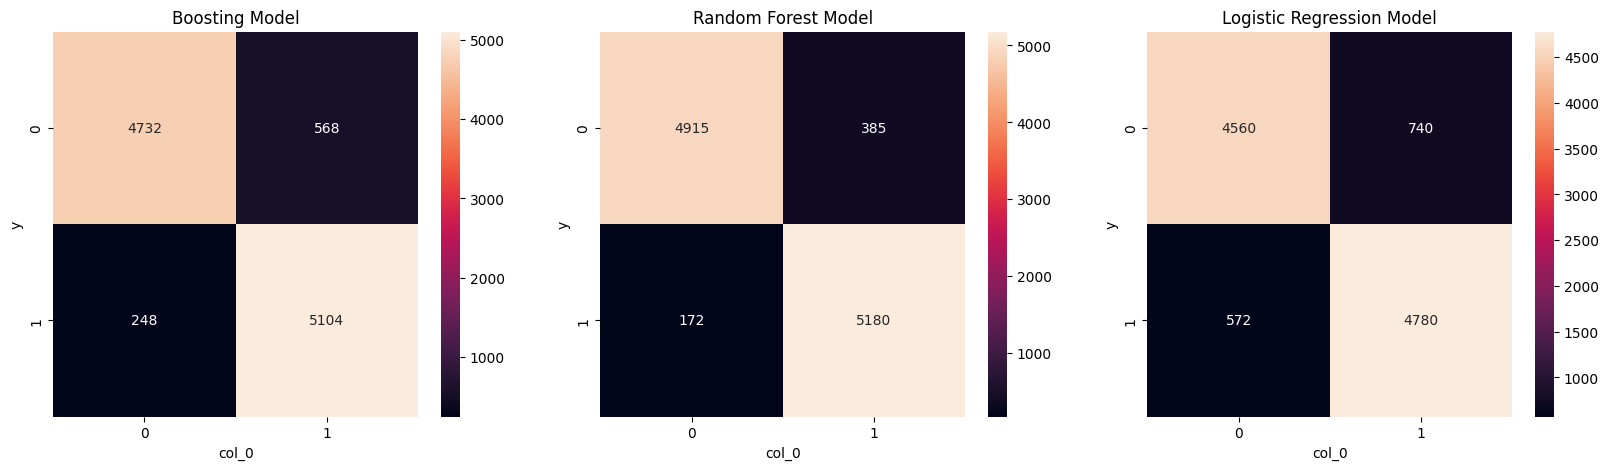

In [20]:
# plot model evaluation
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(pd.crosstab(y_test, boosting_predictions), annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Boosting Model')
sns.heatmap(pd.crosstab(y_test, rf_predictions), annot=True, fmt='d', ax=ax[1])
ax[1].set_title('Random Forest Model')
sns.heatmap(pd.crosstab(y_test, logreg_predictions), annot=True, fmt='d', ax=ax[2])
ax[2].set_title('Logistic Regression Model')
plt.show()

Based on heatmap above random forest model miss classify is below 500, compared it with boosting model that have poor predict on label 1 with miss predict 590 and logistic regression model with miss predict above 500 for both labels

# Feature importances

Last phase is feature importance analysis. the purpose of this analysis is to determine what is the most influential feature when model predicts. we can use attribute feature_importances_ and coef_0 to determine feature importances

In [21]:
# check feature importances to determine which features are most influential
feature_importances_boosting = pd.DataFrame({'Boosting model feature': X.columns, 'Importance': boosting_model.feature_importances_})
feature_importances_boosting.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importances:")
print(feature_importances_boosting)

feature_importances_rf = pd.DataFrame({'Random Forest model feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances_rf.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importances:")
print(feature_importances_rf)

#since logistic regression does not have a feature_importances_ attribute, we use coef_ attribute
feature_importances_logreg = pd.DataFrame({'Logistic Regression model feature': X.columns, 'Importance': logreg_model.coef_[0]}) 
feature_importances_logreg.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importances:")
print(feature_importances_logreg)

Feature Importances:
     Boosting model feature  Importance
10                 duration    0.547471
19              nr.employed    0.249023
11                 campaign    0.068609
17            cons.conf.idx    0.043781
18                euribor3m    0.016293
7                   contact    0.012692
15             emp.var.rate    0.012271
12                    pdays    0.012178
16           cons.price.idx    0.010506
8                     month    0.008870
20  total_previous_contacts    0.004873
0                       age    0.004147
6                      loan    0.003358
13                 previous    0.001868
9               day_of_week    0.001132
14                 poutcome    0.001125
5                   housing    0.000966
3                 education    0.000588
2                   marital    0.000127
1                       job    0.000123
4                   default    0.000000
21     contacted_last_month    0.000000
Feature Importances:
   Random Forest model feature    Impo

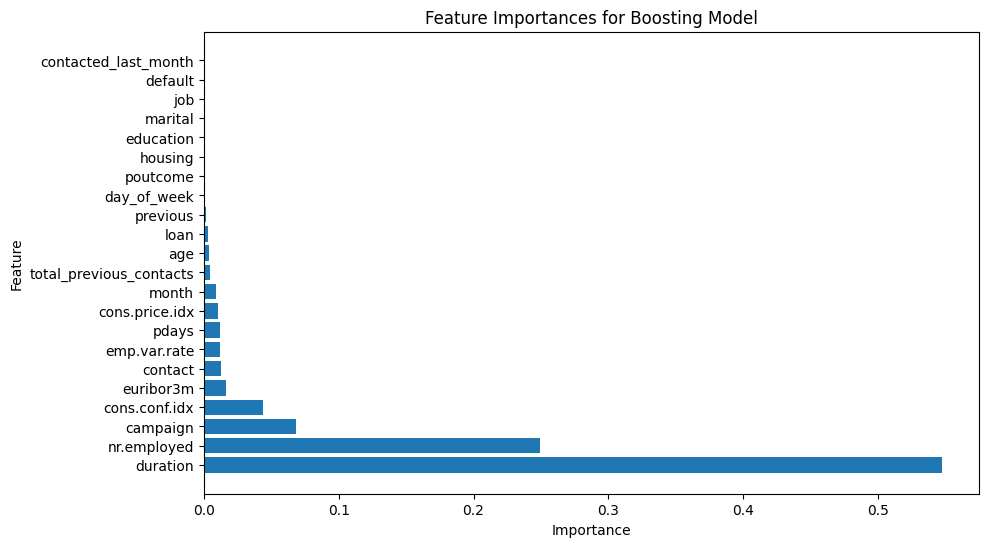

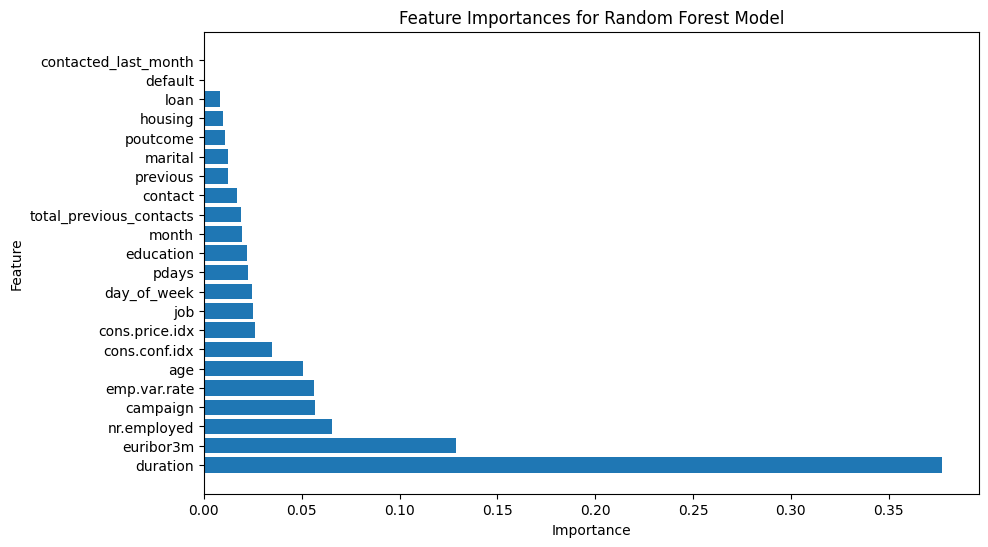

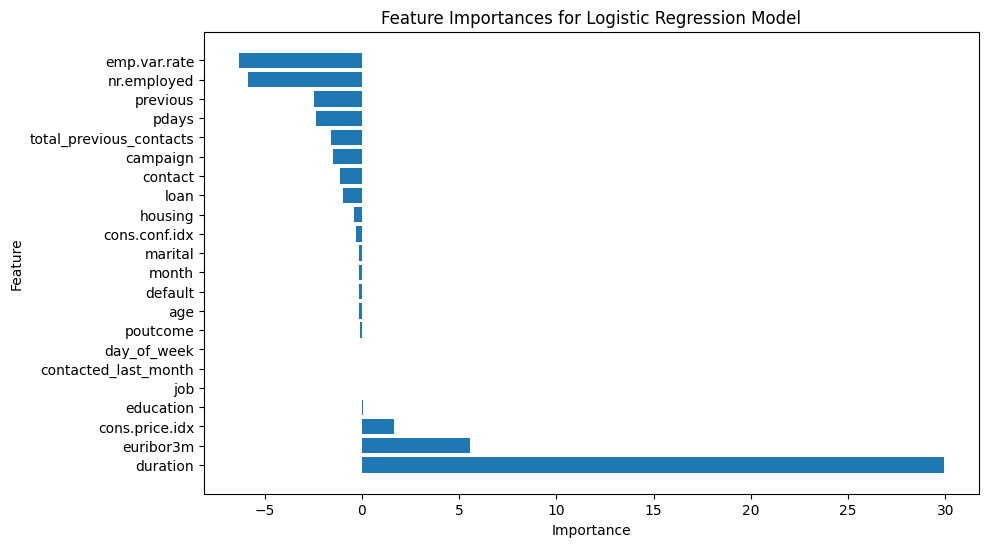

In [22]:
# plot the feature importances and classification report

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_boosting['Boosting model feature'], feature_importances_boosting['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Boosting Model')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_rf['Random Forest model feature'], feature_importances_rf['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest Model')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_logreg['Logistic Regression model feature'], feature_importances_logreg['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Logistic Regression Model')
plt.show()

In a Random Forest model, feature importance is derived from the reduction in impurity attributed to each feature. The values are normalized to sum to 1.

#### 1. duration 
   - **Influence:** This feature has the highest importance, indicating a significant role in determining outcomes.
   - **Why:** Duration suggests customer engagement; longer durations may lead to positive outcomes (subscribing).

#### 2. euribor3m 
   - **Influence:** The second most important feature.
   - **Why:** Euribor 3-month rate, a key economic indicator, influences interest rates and customer decisions on term deposits.

#### 3. nr.employed 
   - **Influence:** Third in importance.
   - **Why:** Reflects the number of employed people, potentially indicating economic stability impacting customer decisions.

#### 4. campaign 
   - **Influence:** Moderate importance.
   - **Why:** The number of contacts during the campaign influences customer decisions; too many contacts may lead to disinterest.

#### 5. emp.var.rate 
   - **Influence:** Moderate importance.
   - **Why:** Employment variation rate indicates economic stability, impacting customers' willingness to commit.

#### 6. age 
   - **Influence:** Moderate importance.
   - **Why:** Age could be a relevant factor; different age groups may have distinct financial behaviors.

#### 7. cons.price.idx 
   - **Influence:** Moderate importance.
   - **Why:** Consumer price index reflects inflation rates, influencing customers' financial decisions.

#### 8. cons.conf.idx 
   - **Influence:** Similar importance to cons.price.idx.
   - **Why:** Consumer confidence index can impact customers' confidence in financial commitments.

#### 9. job 
   - **Influence:** Moderate importance.
   - **Why:** Different job types may have varying propensities to subscribe to term deposits.

#### 10. month 
   - **Influence:** Moderate importance.
   - **Why:** The month might correlate with specific financial patterns or seasons.

#### 11. day_of_week 
   - **Influence:** Moderate importance.
   - **Why:** Days of the week might influence customers' availability and receptiveness to marketing.

# Third-party data

Incorporating third-party data into a machine learning model requires a systematic assessment to ensure its relevance, quality, and positive contribution to the model's performance. To assess third-party data we have to things to check :

1. **Relevance** <br>
The data must be relevance with model initial objective

2. **Data exploration** <br>
Examine data distribution, summary statistics, and anomalies

3. **Data quality** <br>
Check if the data contain missing values, outliers, inconsistencies, etc.

4. **Data compability** <br>
Ensure that third-party data is compatible with existing dataset

5. **model performance assessment** <br>
Train and test the model with and without third-party data and compare the performance metrics to assess the impact of the third-party data
